# VGG16 with Fine Tuning
* $test\_accuracy_{12} = 0.7994$
* $test\_accuracy_{10} = 0.8051$
* $test\_accuracy_{8} = 0.8249$
* $test\_accuracy_{6} = 0.7881$

where $test\_accuracy_{k}$ indicates the Fine Tuning of the VGG16 Net with the first $k$ layers freezed. Obviously, we choose $k$ as 
$k^* = \underset{k}{\operatorname{argmax}}\{test\_accuracy_{k}\}$.

You can find and download the best "base" model here: https://drive.google.com/drive/folders/1038wX3puB1yI9qgvyV1oU1CAP3R4H9hc

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/University/Artificial Neural Networks and Deep Learning Exercises/ANNDL-H1/Christian Spano Folder/Pre-Trained Models

/gdrive/.shortcut-targets-by-id/1ZfYa9Xtbi6bxURrHSnWZqE9FXmV_9dMl/ANNDL-H1/Christian Spano Folder/Pre-Trained Models


### Install some modules

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import the needed (external) libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Import personal libraries

In [ ]:
import sys
sys.path.insert(0, '/gdrive/My Drive/University/Artificial Neural Networks and Deep Learning Exercises/ANNDL-H1/Christian Spano Folder/Utils')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration
Configure the helper classes by setting a seed and the root folder path.

### Define some useful constants

In [ ]:
seed = 9992812
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4',4: 'Species5', 5: 'Species6', 6: 'Species7', 7: 'Species8'}
dataset_folder = "../../"
models_folder = "../Local Files"

### Dataset Configuration

In [ ]:
dataset_helper = DatasetHelper(dataset_folder, seed)

### Models Configuration

In [ ]:
model_helper = ModelHelper(models_folder, labels) #take in input local models folder and lables
model_helper.create_seed(tf, seed);

# Loading the dataset

In [ ]:
# Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()

dataset_size = X.shape[0]
print("Dataset Size: ", dataset_size)

#SPLIT and NORMALIZE OUR DATASET
X_train, X_test, X_val, Y_train, Y_test, Y_val = dataset_helper.split_and_normalize(X, Y, split_test=0.1, split_val=0.1, normalization_mode=1)

#GENERATE 3000 new images
#X_train, Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train, Y_train, 1000, [0.3, 0.05, 0.05, 0.05, 0.05, 0.3, 0.05, 0.05])


Dataset Size:  3542


In [ ]:
X_t_original = X_train
Y_t_original = Y_train

In [ ]:
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 12500, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=1.0,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.5, 1.1))

Data Augmentation with data distribution
Data distribution = [0.1417  0.11922 0.12026 0.12058 0.1193  0.1393  0.1189  0.12074]
Class Size :  151, generating: 1771
1661 images generated
Class Size :  432, generating: 1490
1424 images generated
Class Size :  419, generating: 1503
1385 images generated
Class Size :  415, generating: 1507
1501 images generated
Class Size :  431, generating: 1491
1421 images generated
Class Size :  181, generating: 1741
1629 images generated
Class Size :  436, generating: 1486
1436 images generated
Class Size :  413, generating: 1509
1495 images generated


# Target Classes Visualization

KeyboardInterrupt: ignored

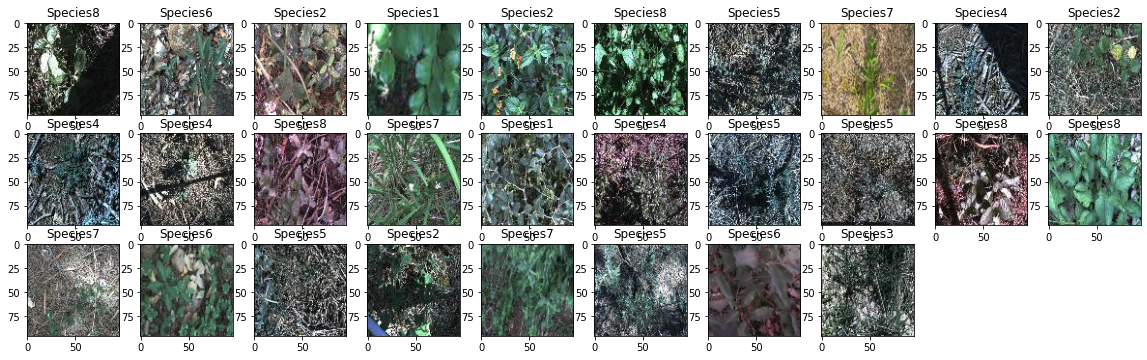

In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns, rows = 10, 10
classe = 2
filter_classes = False
for i in range(1, columns*rows + 1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text(labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i = i-1
fig.tight_layout()
plt.show()

# Build the model

### Fine Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = model_helper.load_model('VGG16-FineTuningMoreAug_6FreezedLayers_New')
ft_model.summary()

Model: "VGG16-DiffAugmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)      

In [ ]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:6]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "VGG16-DiffAugmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)            

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Train the model
#Create ALL desired callbacks
path = "/gdrive/My Drive/University/Artificial Neural Networks and Deep Learning Exercises/ANNDL-H1/Christian Spano Folder/Local Files/local_checkpoints/"
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=20, where_to_save=path, model_name="VGG16-FineTuningMoreAug_6FreezedLayers_New")

#Fit the model
history = ft_model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 128,
    epochs = 35,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/35
116/116 [==============================] - 42s 255ms/step - loss: 0.6849 - accuracy: 0.7633 - val_loss: 0.1646 - val_accuracy: 0.9403
Epoch 2/35
116/116 [==============================] - 26s 221ms/step - loss: 0.4597 - accuracy: 0.8336 - val_loss: 0.0969 - val_accuracy: 0.9623
Epoch 3/35
116/116 [==============================] - 26s 225ms/step - loss: 0.3346 - accuracy: 0.8801 - val_loss: 0.1219 - val_accuracy: 0.9623
Epoch 4/35
116/116 [==============================] - 26s 227ms/step - loss: 0.2583 - accuracy: 0.9081 - val_loss: 0.1106 - val_accuracy: 0.9654
Epoch 5/35
116/116 [==============================] - 26s 228ms/step - loss: 0.1789 - accuracy: 0.9364 - val_loss: 0.1174 - val_accuracy: 0.9528
Epoch 6/35
116/116 [==============================] - 27s 233ms/step - loss: 0.1694 - accuracy: 0.9423 - val_loss: 0.1790 - val_accuracy: 0.9465
Epoch 7/35
116/116 [==============================] - 27s 233ms/step - loss: 0.1410 - accuracy: 0.9502 - val_loss: 0.1634 - val_ac

# Save the model

In [ ]:
model_helper.save_model(ft_model, "VGG16-FineTuningMoreAug_6FreezedLayers_New3")

In [ ]:
model = model_helper.load_model("VGG16-FineTuningMoreAug_6FreezedLayers_New3")
model.summary()

Model: "VGG16-DiffAugmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)      

12/12 [==============================] - 2s 56ms/step
Accuracy: 0.9492
Precision: 0.9429
Recall: 0.9566
F1: 0.9479


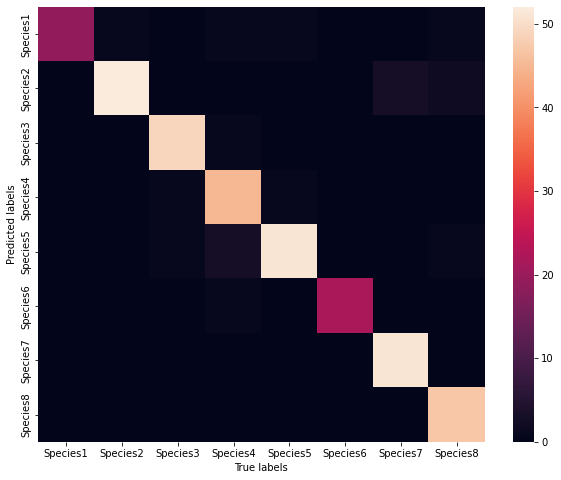

BABABA


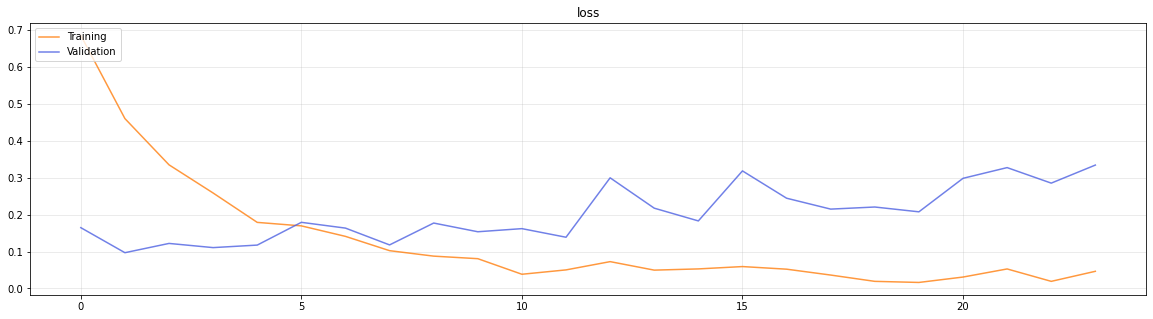

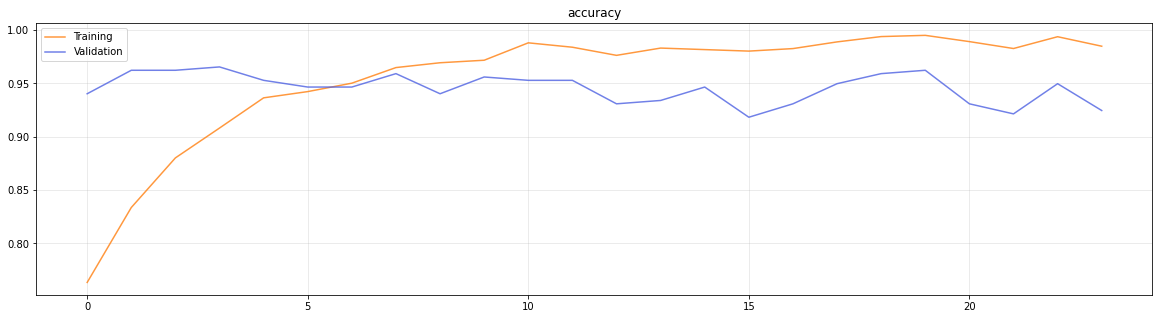

In [ ]:
model_helper.show_confusion_matrix(X_test, Y_test)
model_helper.plot_phase_train_vs_validation(history)